<a href="https://colab.research.google.com/github/ManDes71/Rakuten_Text_Classification_ML/blob/main/notebooks/Modele_RandomForest_tdidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Google Colab -> Cette cellule est à executer (1 fois) pour le cloner le dépot en local***  
il est possible que google colab vous demande re demarrer la session

In [1]:
!git clone https://github.com/ManDes71/Rakuten_Text_Classification_ML.git

Cloning into 'Rakuten_Text_Classification_ML'...
remote: Enumerating objects: 699, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 699 (delta 138), reused 171 (delta 101), pack-reused 468
Receiving objects: 100% (699/699), 72.25 MiB | 21.56 MiB/s, done.
Resolving deltas: 100% (367/367), done.
Updating files: 100% (68/68), done.
Error downloading object: fichiers/GradientBoosting_dump.joblib (c7226a2): Smudge error: Error downloading fichiers/GradientBoosting_dump.joblib (c7226a2f992cd2db58168d60f651bfa4e8c5864356c48efc9b75567d7c3583dc): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/Rakuten_Text_Classification_ML/.git/lfs/logs/20240229T140520.689913932.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: fichiers/GradientBoosting_dump.jobli


***Google Colab -> Cette cellule est à executer (2 fois) pour installer les bibliothèques nécessaires***  
You must restart the runtime in order to use newly installed versions

In [1]:
import sys
sys.path.append('/content/Rakuten_Text_Classification_ML/src')

!pip install -r /content/Rakuten_Text_Classification_ML/requirements.txt

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
# set the max columns to none
pd.set_option('display.max_columns', None)
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import configparser
import sys
sys.path.append('../src')
#sys.path.append('/content/Rakuten_Text_Classification_ML/src')
import Bibli_DataScience_3_1 as ds
config = configparser.ConfigParser()
#config.read('Rakuten_config_colab.ini')
config.read('Rakuten_config.ini')

section :  ['DOSSIER', 'FICHIER']


[]

In [4]:
import pandas as pd

# lecture des données sources d'entrainement
df_feats=pd.read_csv(ds.get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(ds.get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

# récupération du fichier df_langue.csv
df_langue=pd.read_csv(ds.get_RACINE_DOSSIER() + 'df_langue.csv')
df=df.merge(df_langue.drop(['Unnamed: 0','prdtypecode'], axis=1),on='Id',how='inner')
df_feats['PAYS_LANGUE'] = df['PAYS_LANGUE']


Lcat=df_target.sort_values(by='prdtypecode')['prdtypecode'].unique()


nomenclature=pd.read_csv(ds.get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']

#
stopwordFR = pd.read_csv(ds.get_RACINE_DOSSIER() + 'stopwords_FR_02.csv')
stop_words = stopwordFR['MOT'].tolist()


In [5]:
df_feats

,Unnamed: 0,designation,description,productid,imageid,PAYS_LANGUE
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,de
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,fr
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,fr
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,de
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,ca
...,...,...,...,...,...,...
84911,84911,The Sims [ Import Anglais ],NaN,206719094,941495734,en
84912,84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883,fr
84913,84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617,fr
84914,84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403,fr


In [ ]:
df_target

,Unnamed: 0,prdtypecode
0,0,10
1,1,2280
2,2,50
3,3,1280
4,4,2705
...,...,...
84911,84911,40
84912,84912,2583
84913,84913,2280
84914,84914,1560


*préprocessing utilisé :*
 1. concaténation des champs "désignation" et "description"
 2. traitement des phrases avec une expression régulière :  `r = re.compile(r"[a-zA-Z0-9âéè°]{2,}")`  
	 on ne garde	que certains caractères et les mots d'au moins 2 caractères
 3.  on découpe chaque phrase en une liste de mots : word_tokenize
 4.  on met tous les mots de la phrase en minuscule
 5.  on retire les stopswords par langue en utilisant le module nltk.corpus

In [6]:
def combine_description_and_designation(row):
    partie_design = row['designation'] if isinstance(row['designation'], str) else ''
    partie_descrip = row['description'] if isinstance(row['description'], str) else ''
    return partie_design + ' ' + partie_descrip if len(partie_descrip) > 0 else partie_design

# Appliquer la fonction à chaque ligne
df_feats['design_descrip'] = df_feats.apply(combine_description_and_designation, axis=1)

In [7]:
def clean_sentence(sentence,langue):
        if langue == 'en':
            SW = stopwords.words('english')
        elif langue == 'fr':
            SW = stopwords.words('french')
        elif langue == 'de':
            SW = stopwords.words('german')
        elif langue == 'ca':
            SW = stopwords.words('french')
        elif langue == 'nl':
            SW = stopwords.words('dutch')
        elif langue == 'it':
            SW = stopwords.words('italian')
        elif langue == 'es':
            SW = stopwords.words('spanish')
        else:
            SW = stopwords.words('french')
         # Pour chaque mot de la phrase (dans l'ordre inverse)
        for i, word in reversed(list(enumerate(sentence))):
                # Si le mot est un stopword
                if word in SW :
                    # On l'enlève de l'artikle
                    sentence.pop(i)
        return sentence
def dictionarize(article,langue):
        r = re.compile(r"[a-zA-Z0-9âéè°]{2,}")
        #dico ={}
        ListMots =[]
        sent = ' '.join(r.findall(article))
        ## Etape 3: Découper chaque phrase en une liste de mots
        sent = word_tokenize(sent)
        ## Etape 4: Mettre tous les mots de la phrase en minuscule
        sent_lower = [word.lower() for word in sent]
        ## Etape 5: Retirer les stopwords de chaque liste.
        sent_clean = clean_sentence(sent_lower,langue)
        #dico[i]=sent_clean
        ListMots.append(sent_clean)
        resultat = []

        for sous_liste in ListMots:
            resultat.extend(sous_liste)

        return resultat


def decomposition(article,langue):

        artikle = dictionarize(article,langue)
        artikle = [mot for mot in artikle if mot not in stop_words]

        return artikle

In [8]:
df_feats['phrases'] = df_feats.apply(lambda x :decomposition(str(x.design_descrip),str(x.PAYS_LANGUE)), axis=1)

#### 1er test : SVC sans paramètres

In [ ]:
X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])

X_train = X_train_avant['phrases'].apply(lambda x: ' '.join(x))
X_test = X_test_avant['phrases'].apply(lambda x: ' '.join(x))
y_train = y_train_avant['prdtypecode']
y_test = y_test_avant['prdtypecode']

# Créer un pipeline qui transforme les données, puis les adapte à un modèle SVM
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True,max_df=0.8, min_df=2)),
    ('clf', RandomForestClassifier(n_jobs=-1, random_state=321)),
])

# Entraînez le modèle
text_clf.fit(X_train, y_train)

# Testez le modèle sur l'ensemble de test
y_pred = text_clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score: ", f1)
accuracy = text_clf.score(X_test, y_test)
print("Accuracy: ", accuracy)

F1 Score:  0.7860630478457473
Accuracy:  0.7848731399207793


F1 Score:  0.7860630478457473
Accuracy:  0.7848731399207793

In [ ]:
# Obtenir tous les paramètres du pipeline
params = text_clf.get_params()

# Filtrer les paramètres pour obtenir seulement ceux relatifs à `RandomForestClassifier`
rf_params = {param_name: value for param_name, value in params.items() if 'clf__' in param_name}

print(rf_params)

{'clf__bootstrap': True, 'clf__ccp_alpha': 0.0, 'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__max_leaf_nodes': None, 'clf__max_samples': None, 'clf__min_impurity_decrease': 0.0, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__min_weight_fraction_leaf': 0.0, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__oob_score': False, 'clf__random_state': 321, 'clf__verbose': 0, 'clf__warm_start': False}


### Grille de recherche  
Recherches des paramètres optimaux :   
**grille**  = {
            'clf__n_estimators': [50,100,150],
            'clf__max_features': [ 'sqrt'],
            'clf__max_depth': [None],
            'clf__criterion': [ 'entropy','gini']}
           #'tfidf__max_df': [ 0.3,0.4,0.5], # Ignore les termes qui apparaissent dans plus de max_df % des documents. Utilisé pour éliminer les termes trop fréquents qui sont moins informatifs.
           # 'tfidf__min_df': [18,30,50] #  Ignore les termes qui apparaissent dans moins de min_df documents. Utilisé pour éliminer les termes trop rares.

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import f1_score, make_scorer


X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])


X_train = X_train_avant['phrases'].apply(lambda x: ' '.join(x))
X_test = X_test_avant['phrases'].apply(lambda x: ' '.join(x))
y_train = y_train_avant['prdtypecode']
y_test = y_test_avant['prdtypecode']

# Créer un pipeline qui transforme les données, puis les adapte à un modèle RandomForestClassifier
pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(lowercase=True,max_df=0.8, min_df=2)),
            ('clf', RandomForestClassifier(n_jobs=-1, random_state=321))
        ])

parametres = {'clf__n_estimators': [50,100,150],'clf__max_features': ['sqrt'],'clf__max_depth': [None],'clf__criterion': [ 'entropy','gini']}

scorer = make_scorer(f1_score, average='weighted')
grid_search = model_selection.GridSearchCV(pipeline, param_grid=parametres,cv=5, scoring=scorer)
grille = grid_search.fit(X_train, y_train)
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score F1 :", grid_search.best_score_)
y_pred = grid_search.predict(X_test)

Meilleurs paramètres : {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 150}
Meilleur score F1 : 0.7815573444684798


In [ ]:
Meilleurs paramètres : {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 150}
Meilleur score F1 : 0.7815573444684798

### Meilleur modèle

In [9]:
X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])

X_train = X_train_avant['phrases'].apply(lambda x: ' '.join(x))
X_test = X_test_avant['phrases'].apply(lambda x: ' '.join(x))
y_train = y_train_avant['prdtypecode']
y_test = y_test_avant['prdtypecode']

# Créer un pipeline qui transforme les données, puis les adapte à un modèle SVM
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True,max_df=0.8, min_df=2)),
    ('clf', RandomForestClassifier(n_jobs=-1,
        random_state=321,
        criterion='gini',
        max_depth=None,
        max_features='sqrt',
        n_estimators=150  )),
])

# Entraînez le modèle
text_clf.fit(X_train, y_train)

# Testez le modèle sur l'ensemble de test
y_pred = text_clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score: ", f1)
accuracy = text_clf.score(X_test, y_test)
print("Accuracy: ", accuracy)

F1 Score:  0.7884277453294796
Accuracy:  0.7872283481425971


F1 Score:  0.7884277453294796  
Accuracy:  0.7872283481425971

### SAUVEGARDE DU MODELE

In [ ]:
from joblib import dump
dump(text_clf, ds.get_RACINE_SAUVEGARDE() +'RandomForest_TfIdf.joblib')

['E:/Manuel/PROJET/Rakuten_Text_Classification_ML/fichiers/RandomForest_TfIdf.joblib']

### RECUPERATION DU MODELE

In [ ]:
from joblib import load
text_clf = load(ds.get_RACINE_SAUVEGARDE() + 'RandomForest_TfIdf.joblib')

In [ ]:
total=(y_pred ==  y_test)

In [ ]:
df_test = X_test_avant.merge(y_test_avant,on='Unnamed: 0',how='inner')
df_test['predict']=y_pred
df_test.head()


,Unnamed: 0,designation,description,productid,imageid,PAYS_LANGUE,design_descrip,phrases,prdtypecode,predict
0,48911,Coffret 5 Pièces Peppa Pig,<p>Vaisselle pour le repas des tout-petits fab...,3900805892,1261630470,fr,Coffret 5 Pièces Peppa Pig <p>Vaisselle pour l...,"[coffret, pièces, peppa, pig, vaisselle, repas...",1320,1320
1,22412,Jacobs Lungo 8 Intenso Capsules De Café Compat...,Ce lungo se caractérise par la torréfaction pr...,4056000876,1282290576,fr,Jacobs Lungo 8 Intenso Capsules De Café Compat...,"[jacobs, lungo, intenso, capsules, café, compa...",1940,1940
2,19061,Eon Altar: Episode 2 - Whispers In The Catacom...,<div> <p> <strong>NOTE :</strong> un compte St...,2017625778,1120710502,fr,Eon Altar: Episode 2 - Whispers In The Catacom...,"[eon, altar, episode, whispers, catacombs, ext...",2905,2905
3,26343,D - Livre 1,Quand un jeune homme se retrouve projet&eacute...,688661390,1061771602,fr,D - Livre 1 Quand un jeune homme se retrouve p...,"[livre, jeune, homme, retrouve, projet, monde,...",2705,2705
4,67827,Tommee Tippee - 82037101 - Sangenic - Lot De 6...,<br>Nouvelle recharge Tomme Tippee compatible ...,304796550,996077810,fr,Tommee Tippee - 82037101 - Sangenic - Lot De 6...,"[tommee, tippee, 82037101, sangenic, lot, nouv...",1320,2583


### Tableau des repartitions des **classes prédites** pour chaque **classe réelle**

In [ ]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    print(df_test[df_test['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.670073
2403    0.113869
2280    0.078832
2705    0.072993
40      0.026277
Name: proportion, dtype: float64
40    ------    jeux video pour pc et consoles
predict
40      0.626812
10      0.121377
50      0.056159
2462    0.041667
1281    0.036232
Name: proportion, dtype: float64
50    ------     accesoires jeux video
predict
50      0.748649
2462    0.078378
40      0.045946
1300    0.024324
10      0.021622
Name: proportion, dtype: float64
60    ------    consoles de jeux video
predict
60      0.775956
50      0.076503
2462    0.076503
40      0.027322
1281    0.016393
Name: proportion, dtype: float64
1140    ------    produits derives “geeks” et figurines
predict
1140    0.758503
10      0.047619
1280    0.039116
2280    0.032313
1160    0.018707
Name: proportion, dtype: float64
1160    ------    cartes collectionables
predict
1160    0.914943
10      0.041379
2280    0.010345
40      0.005747
2403    0.005747
Name: proportion, dtype: float64

### Tableau croisé  

In [ ]:

df_cross=pd.crosstab(df_test['prdtypecode'], df_test['predict'],normalize='index')
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1281,1300,1301,1302,1320,1560,1920,1940,2060,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,0.670073,0.026277,0.000000,0.000000,0.002920,0.007299,0.001460,0.005839,0.001460,0.002920,0.000000,0.000000,0.004380,0.000000,0.000000,0.000000,0.000000,0.000000,0.078832,0.113869,0.001460,0.007299,0.000000,0.001460,0.001460,0.072993,0.000000
40,0.121377,0.626812,0.056159,0.000000,0.010870,0.005435,0.000000,0.023551,0.036232,0.001812,0.000000,0.000000,0.001812,0.003623,0.000000,0.001812,0.009058,0.000000,0.014493,0.027174,0.041667,0.001812,0.000000,0.000000,0.000000,0.016304,0.000000
50,0.021622,0.045946,0.748649,0.000000,0.018919,0.008108,0.000000,0.002703,0.000000,0.024324,0.000000,0.000000,0.010811,0.008108,0.000000,0.000000,0.013514,0.000000,0.000000,0.000000,0.078378,0.008108,0.000000,0.002703,0.002703,0.002703,0.002703
60,0.010929,0.027322,0.076503,0.775956,0.000000,0.000000,0.005464,0.000000,0.016393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076503,0.010929,0.000000,0.000000,0.000000,0.000000,0.000000
1140,0.047619,0.018707,0.003401,0.000000,0.758503,0.018707,0.011905,0.039116,0.013605,0.003401,0.000000,0.006803,0.006803,0.000000,0.001701,0.000000,0.005102,0.000000,0.032313,0.017007,0.001701,0.005102,0.000000,0.001701,0.000000,0.006803,0.000000
1160,0.041379,0.005747,0.000000,0.000000,0.003448,0.914943,0.001149,0.003448,0.004598,0.001149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010345,0.005747,0.001149,0.001149,0.000000,0.000000,0.001149,0.004598,0.000000
1180,0.089286,0.047619,0.000000,0.000000,0.071429,0.023810,0.553571,0.053571,0.059524,0.005952,0.000000,0.000000,0.000000,0.005952,0.000000,0.000000,0.017857,0.000000,0.017857,0.023810,0.011905,0.000000,0.005952,0.005952,0.005952,0.000000,0.000000
1280,0.034547,0.004669,0.001867,0.000000,0.075630,0.007470,0.001867,0.582633,0.046685,0.144725,0.000000,0.015873,0.018674,0.009337,0.000000,0.000000,0.014006,0.000934,0.004669,0.007470,0.002801,0.014006,0.002801,0.007470,0.000000,0.001867,0.000000
1281,0.037363,0.039560,0.002198,0.000000,0.024176,0.026374,0.015385,0.213187,0.527473,0.006593,0.000000,0.008791,0.006593,0.004396,0.000000,0.000000,0.004396,0.000000,0.015385,0.015385,0.006593,0.015385,0.000000,0.004396,0.002198,0.024176,0.000000


### Tableau des repartitions des **classes prédites** pour chaque **classe réelle** avec libellés.

In [ ]:
for c in Lcat:
    print(c,'   ------   ', catdict[c])
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    for index, value in s.items():  # Utilisez items() au lieu de iteritems()
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")

10    ------    livres
  : 10,  : 67.01 % , livres
  : 2403,  : 11.39 % , livres et bds
  : 2280,  : 7.88 % , magazines
  : 2705,  : 7.3 % , bds et livres
  : 40,  : 2.63 % , jeux video pour pc et consoles
40    ------    jeux video pour pc et consoles
  : 40,  : 62.68 % , jeux video pour pc et consoles
  : 10,  : 12.14 % , livres
  : 50,  : 5.62 % ,  accesoires jeux video
  : 2462,  : 4.17 % , consoles de jeux video et jeux videos
  : 1281,  : 3.62 % , jeux de societe/cartes
50    ------     accesoires jeux video
  : 50,  : 74.86 % ,  accesoires jeux video
  : 2462,  : 7.84 % , consoles de jeux video et jeux videos
  : 40,  : 4.59 % , jeux video pour pc et consoles
  : 1300,  : 2.43 % , Petites voitures (jouets) et maquettes
  : 10,  : 2.16 % , livres
60    ------    consoles de jeux video
  : 60,  : 77.6 % , consoles de jeux video
  : 50,  : 7.65 % ,  accesoires jeux video
  : 2462,  : 7.65 % , consoles de jeux video et jeux videos
  : 40,  : 2.73 % , jeux video pour pc et consoles
 

### Rapport de classification

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          10       0.38      0.67      0.49       685
          40       0.72      0.63      0.67       552
          50       0.80      0.75      0.77       370
          60       0.99      0.78      0.87       183
        1140       0.73      0.76      0.75       588
        1160       0.90      0.91      0.91       870
        1180       0.80      0.55      0.65       168
        1280       0.66      0.58      0.62      1071
        1281       0.64      0.53      0.58       455
        1300       0.84      0.92      0.88      1110
        1301       0.99      0.85      0.92       178
        1302       0.91      0.67      0.77       548
        1320       0.80      0.72      0.76       713
        1560       0.77      0.81      0.79      1116
        1920       0.89      0.90      0.89       947
        1940       0.96      0.78      0.86       177
        2060       0.74      0.79      0.77      1098
        2220       0.95    

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print(cm[:10,:10])
print('*************************************************')
print(cm[10:20,10:20])
print('*************************************************')
print(cm[20:,20:])

[[ 459   18    0    0    2    5    1    4    1    2]
 [  67  346   31    0    6    3    0   13   20    1]
 [   8   17  277    0    7    3    0    1    0    9]
 [   2    5   14  142    0    0    1    0    3    0]
 [  28   11    2    0  446   11    7   23    8    2]
 [  36    5    0    0    3  796    1    3    4    1]
 [  15    8    0    0   12    4   93    9   10    1]
 [  37    5    2    0   81    8    2  624   50  155]
 [  17   18    1    0   11   12    7   97  240    3]
 [  20    2    1    0    1    2    0   34    2 1021]]
*************************************************
[[151   2   2   5   0   0   0   0   0   0]
 [  0 367  16  14   0   0   8   1   6   6]
 [  0   2 515  19  16   0  27   0   6  10]
 [  0   0  11 901  27   0  91   1   2   1]
 [  0   0   9  28 851   0  36   0   2   4]
 [  0   0   4   1   0 138   2   0   4   1]
 [  1   2  17  79  40   1 869   0   7   3]
 [  0   0   6   6   2   1  11 110   2   1]
 [  0   0   2   0   0   0   3   0 813  51]
 [  0   0   4   0   0   0   1   

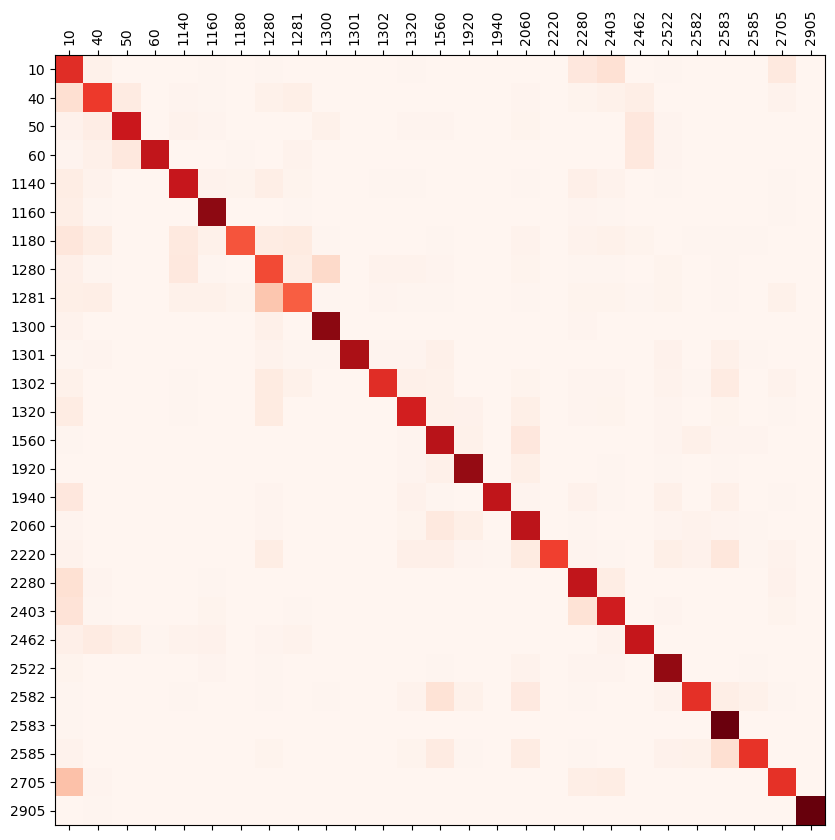

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
#cm_normalized=cm.div(cm.sum(axis=1), axis=0)
cax = ax.matshow(cm_normalized, cmap='Reds')
plt.xticks(range(27),catdict,rotation=90)
plt.yticks(range(27),catdict,rotation=0)
plt.show()

## Etude des catégories 10 ; 2280 ; 2403 ; 2705

In [ ]:
df_livres=df_test[df_test['prdtypecode'].isin([10,2280,2403,2705])]
vectorizer=text_clf.named_steps['tfidf']

### Tableau des repartitions des **classes predites** pour chaque `classe réelle`

In [ ]:

for c in [10,2280,2403,2705]:
    print(c,'   ------   ', catdict[c] )
    print(df_livres[df_livres['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.670073
2403    0.113869
2280    0.078832
2705    0.072993
40      0.026277
Name: proportion, dtype: float64
2280    ------    magazines
predict
2280    0.776504
10      0.120344
2403    0.048711
2705    0.022923
40      0.008596
Name: proportion, dtype: float64
2403    ------    livres et bds
predict
2403    0.729524
2280    0.106667
10      0.104762
2705    0.013333
1160    0.012381
Name: proportion, dtype: float64
2705    ------    bds et livres
predict
2705    0.655684
10      0.227348
2403    0.049423
2280    0.039539
40      0.011532
Name: proportion, dtype: float64


### Les 10 mots ayant le **scores TF-IDF** les plus élévés et ceux des rangs de 76 à 80.   
Ces scores aident à identifier les mots qui sont importants dans un document particulier en tenant compte  
de leur fréquence dans ce document et de leur rareté dans l'ensemble du corpus.

In [ ]:
Words = vectorizer.transform(df_livres['designation'])
#help(CountVectorizer)
words = vectorizer.get_feature_names_out()
word_counts = Words.sum(axis=0)
word_count_dict = dict(zip(words, word_counts.tolist()[0]))
#print(word_count_dict)
occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:80]
Dic_words={}
for item in occurrences_triees:
    #print(item[0], ":", item[1])
    Dic_words[item[0]]=item[1]
#print(Dic_words)
df_words=pd.DataFrame.from_dict(Dic_words, orient='index',columns=['Total'])
print(df_words.head(10))
print(df_words.tail())

              Total
lot       93.297337
tome      56.344146
livres    51.999364
01        40.179128
10        38.497605
12        32.783278
11        30.922111
france    30.095782
revue     29.677567
magazine  29.114804
              Total
piano      7.124548
24         7.036313
avril      6.973697
album      6.967048
intégrale  6.873213


### Les 20 mots ayant le **scores TF-IDF** les plus élévés .

In [ ]:
df_total_livres=df_words
words = vectorizer.get_feature_names_out()
for c in [10,2705,2280,2403]:
    X_words = vectorizer.transform(df_livres[df_livres['prdtypecode']==c] ['designation'])
    word_counts = X_words.sum(axis=0)
    word_count_dict = dict(zip(words, word_counts.tolist()[0]))
    occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:20]
    Dic_words={}
    for item in occurrences_triees:
        Dic_words[item[0]]=item[1]
    df_words_X=pd.DataFrame.from_dict(Dic_words, orient='index',columns=[str(c)])
    df_total_livres=df_total_livres.join(df_words_X)
df_total_livres.head(20)

,Total,10,2705,2280,2403
lot,93.297337,NaN,NaN,NaN,92.158471
tome,56.344146,11.650113,21.940619,NaN,21.325055
livres,51.999364,NaN,NaN,NaN,50.275812
01,40.179128,NaN,NaN,36.974804,NaN
10,38.497605,NaN,NaN,19.536979,16.409545
12,32.783278,NaN,NaN,19.277957,12.077328
11,30.922111,3.646027,NaN,20.438734,NaN
france,30.095782,3.912862,NaN,14.726065,9.712943
revue,29.677567,NaN,NaN,16.593297,11.865593
magazine,29.114804,NaN,NaN,20.411596,NaN


### **Heatmap**
couleur Rouge foncée : fréquence très élévée  
couleur Bleu foncée : fréquance très basse  
couleur Blanche : NaN

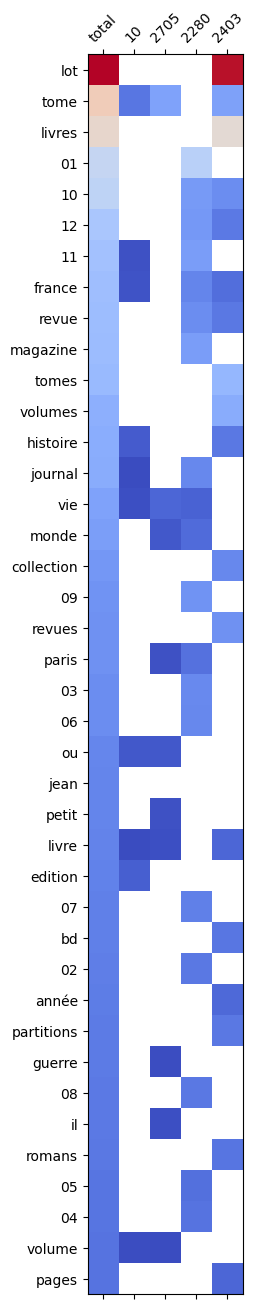

In [ ]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_livres.iloc[0:40], cmap = 'coolwarm')
plt.xticks(range(5),('total','10','2705','2280','2403'),rotation=45)
plt.yticks(range(40),df_total_livres.iloc[0:40].index,rotation=0)
plt.show()


## Etude des catégories 1280,1281

In [ ]:
df_jouets=df_test[df_test['prdtypecode'].isin([1280,1281])]

### Tableau des repartitions des **classes predites** pour chaque `classe réelle`

In [ ]:

for c in [1280,1281]:
    print(c,'   ------   ', catdict[c] )
    print(df_jouets[df_jouets['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

1280    ------    jouets, peluches, poupees
predict
1280    0.582633
1300    0.144725
1140    0.075630
1281    0.046685
10      0.034547
Name: proportion, dtype: float64
1281    ------    jeux de societe/cartes
predict
1281    0.527473
1280    0.213187
40      0.039560
10      0.037363
1160    0.026374
Name: proportion, dtype: float64


### Les 10 mots ayant le **scores TF-IDF** les plus élévés et ceux des rangs de 76 à 80.   
Ces scores aident à identifier les mots qui sont importants dans un document particulier en tenant compte  
de leur fréquence dans ce document et de leur rareté dans l'ensemble du corpus.

In [ ]:
Words = vectorizer.transform(df_jouets['designation'])
#help(CountVectorizer)
words = vectorizer.get_feature_names_out()
word_counts = Words.sum(axis=0)
word_count_dict = dict(zip(words, word_counts.tolist()[0]))
#print(word_count_dict)
occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:80]
Dic_words={}
for item in occurrences_triees:
    #print(item[0], ":", item[1])
    Dic_words[item[0]]=item[1]
#print(Dic_words)
df_words=pd.DataFrame.from_dict(Dic_words, orient='index',columns=['Total'])
print(df_words.head(10))
print(df_words.tail())

             Total
enfants  45.267651
jouet    37.558010
peluche  35.140603
jouets   34.989406
toy      32.252619
doudou   30.234269
puzzle   27.056359
jeu      23.825432
bébé     21.655558
cadeau   21.282932
                  Total
développement  5.803189
boule          5.802947
simulé         5.781250
musique        5.724818
jouer          5.718962


### Les 20 mots ayant le **scores TF-IDF** les plus élévés .   

In [ ]:
df_total_jouets=df_words
words = vectorizer.get_feature_names_out()
for c in [1280,1281]:
    X_words = vectorizer.transform(df_jouets[df_jouets['prdtypecode']==c] ['designation'])
    word_counts = X_words.sum(axis=0)
    word_count_dict = dict(zip(words, word_counts.tolist()[0]))
    occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:20]
    Dic_words={}
    for item in occurrences_triees:
        Dic_words[item[0]]=item[1]
    df_words_X=pd.DataFrame.from_dict(Dic_words, orient='index',columns=[str(c)])
    df_total_jouets=df_total_jouets.join(df_words_X)
df_total_jouets.head(20)

,Total,1280,1281
enfants,45.267651,33.080509,12.187142
jouet,37.558010,29.292394,8.265616
peluche,35.140603,32.579356,NaN
jouets,34.989406,26.024941,8.964465
toy,32.252619,22.019574,10.233046
doudou,30.234269,30.234269,NaN
puzzle,27.056359,22.612416,4.443943
jeu,23.825432,NaN,19.169829
bébé,21.655558,14.665426,6.990132
cadeau,21.282932,15.821260,5.461672


### **Heatmap**
couleur Rouge foncée : fréquence très élévée  
couleur Bleu foncée : fréquance très basse  
couleur Blanche : NaN  

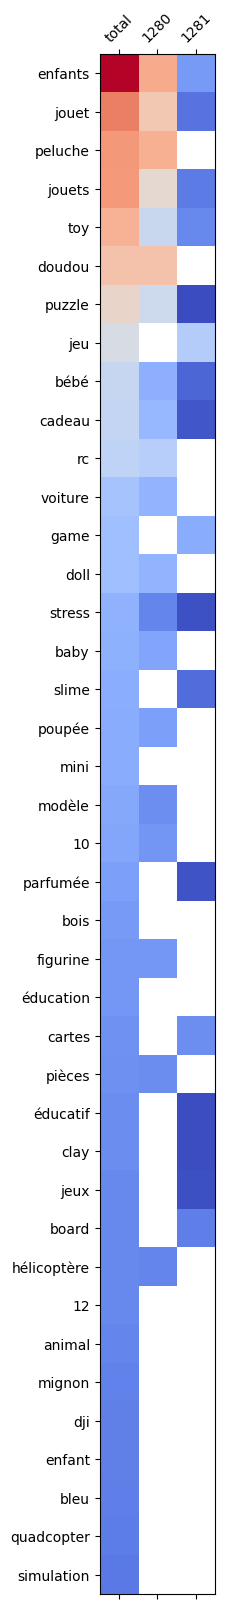

In [ ]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_jouets.iloc[0:40], cmap = 'coolwarm')
plt.xticks(range(3),('total','1280','1281'),rotation=45)
plt.yticks(range(40),df_total_jouets.iloc[0:40].index,rotation=0)
plt.show()